In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost -q

     |████████████████████████████████| 76.8 MB 1.1 MB/s 


In [3]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from ast import literal_eval

In [4]:
data=pd.read_csv('/content/drive/MyDrive/new_corr.csv')

In [5]:
len(os.listdir('/content/drive/MyDrive/networks'))

242

In [6]:
names=[path.split('.')[0] for path in os.listdir('/content/drive/MyDrive/networks')[:-1]]
path_list=[os.path.join('/content/drive/MyDrive/networks',path) for path in os.listdir('/content/drive/MyDrive/networks')[:-1]]
df_list=[]
fields=['lon','lat']
for name,i in tqdm(zip(names,path_list)):
  df=pd.read_csv(i,usecols=fields)
  df['name']=name
  df_list.append(df)
meta_df=pd.concat(df_list)

241it [00:05, 40.84it/s] 


In [7]:
data['lats']=data.lats.apply(lambda x: literal_eval(x))
data['longs']=data.longs.apply(lambda x: literal_eval(x))
data['size']=data.lats.apply(lambda x: len(x))

In [8]:
from math import radians, cos, sin, asin, sqrt
from itertools import combinations
def haversine(lat1, lon1, lat2, lon2):
      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)
      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))
      return R * c

In [9]:
meta_df=pd.merge(meta_df,data,on=['name'],how='right')
meta_df=meta_df.loc[meta_df['size']>2]
meta_df=meta_df.loc[meta_df['no_of_cont']>3]
comb_df=meta_df.groupby(['name']).mean().reset_index()

In [10]:
meta_df

,lat,lon,name,lats,longs,no_of_cont,size
0,34.67279,3.26300,Arn,"[34.67279, 36.26417, 36.47004, 33.35608, 36.65...","[3.263, 2.75393, 2.8277, 6.86319, 5.67186, 2.8...",20,28
1,36.26417,2.75393,Arn,"[34.67279, 36.26417, 36.47004, 33.35608, 36.65...","[3.263, 2.75393, 2.8277, 6.86319, 5.67186, 2.8...",20,28
2,36.47004,2.82770,Arn,"[34.67279, 36.26417, 36.47004, 33.35608, 36.65...","[3.263, 2.75393, 2.8277, 6.86319, 5.67186, 2.8...",20,28
3,33.35608,6.86319,Arn,"[34.67279, 36.26417, 36.47004, 33.35608, 36.65...","[3.263, 2.75393, 2.8277, 6.86319, 5.67186, 2.8...",20,28
4,36.65944,5.67186,Arn,"[34.67279, 36.26417, 36.47004, 33.35608, 36.65...","[3.263, 2.75393, 2.8277, 6.86319, 5.67186, 2.8...",20,28
...,...,...,...,...,...,...,...
11641,43.04690,-76.14440,kaggle2,"[41.7627, 41.7627, 41.7627, 41.7627, 36.1314, ...","[-72.6743, -72.6743, -72.6743, -72.6743, -95.9...",17,1983
11642,29.76040,-95.36980,kaggle2,"[41.7627, 41.7627, 41.7627, 41.7627, 36.1314, ...","[-72.6743, -72.6743, -72.6743, -72.6743, -95.9...",17,1983
11643,39.79100,-86.14800,kaggle2,"[41.7627, 41.7627, 41.7627, 41.7627, 36.1314, ...","[-72.6743, -72.6743, -72.6743, -72.6743, -95.9...",17,1983
11644,39.79100,-86.14800,kaggle2,"[41.7627, 41.7627, 41.7627, 41.7627, 36.1314, ...","[-72.6743, -72.6743, -72.6743, -72.6743, -95.9...",17,1983


In [11]:
for num,(_,cities_df) in enumerate(tqdm(meta_df.groupby(['name']))):
  comb_df.loc[num,'long_ptp']=np.ptp(cities_df.lon)
  comb_df.loc[num,'lat_ptp']=np.ptp(cities_df.lat)
  #comb_df.loc[num,'new_size']=cities_df.shape[0]
  dists=[]
  for loc1,loc2 in combinations(cities_df[['lat','lon']].values,2):
    dist=haversine(loc1[0],loc1[1],loc2[0],loc2[1])
    dists.append(dist)
  comb_df.loc[num,'mean_dist']=np.mean(dists)
  comb_df.loc[num,'median_dist']=np.median(dists)
  comb_df.loc[num,'max_dist']=np.max(dists)
  comb_df.loc[num,'sum_dist']=np.sum(dists)
  comb_df.loc[num,'min_dist']=np.min(dists)
  comb_df.loc[num,'upper_dist']=np.percentile(dists,75)
  comb_df.loc[num,'lower_dist']=np.percentile(dists,25)
  comb_df.loc[num,'std_dist']=np.std(dists)
comb_df['max_area']=comb_df['long_ptp']*comb_df['lat_ptp']

100%|██████████| 205/205 [00:18<00:00, 11.08it/s]


In [12]:
comb_df

,name,lat,lon,no_of_cont,size,long_ptp,lat_ptp,mean_dist,median_dist,max_dist,sum_dist,min_dist,upper_dist,lower_dist,std_dist,max_area
0,Abilene,38.420060,-96.984176,10.0,11.0,48.326100,17.842930,1231.795521,1020.030325,2556.457498,6.774875e+04,163.668676,1773.901583,689.809156,659.620402,862.279219
1,Abvt,39.636781,-66.517069,17.0,22.0,262.257510,26.599760,2712.145722,2169.355937,7465.905245,6.265057e+05,35.552556,4656.959904,993.898054,1972.034246,6975.986824
2,Agis,37.673845,-100.015964,5.0,25.0,51.359650,21.831940,1312.104319,1270.205726,2731.684052,3.936313e+05,5.613699,1978.359564,626.972960,782.215958,1121.280797
3,Airtel,29.263143,21.946504,8.0,9.0,232.401370,50.218860,4937.265381,4974.439883,9534.162714,1.777416e+05,549.341087,6623.947785,2616.404395,2571.501549,11670.931864
4,Ans,37.088329,-98.408116,15.0,18.0,85.173240,26.299270,1518.458906,1237.482676,5011.557960,2.323242e+05,17.154726,2162.594831,679.745368,1121.210356,2239.994036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Xeex,37.922235,-88.277710,17.0,24.0,231.497640,47.199940,2239.009010,1741.962706,9450.224237,6.179665e+05,0.338612,2431.343602,718.274378,2242.684539,10926.674718
201,Xspedius,33.637191,-91.112226,11.0,34.0,38.525030,13.838870,729.401216,640.122101,2169.617338,4.091941e+05,30.150505,963.321083,395.514119,427.463987,533.142882
202,York,53.094147,-1.540870,19.0,23.0,4.157630,5.121620,135.039288,117.302727,387.193673,3.416494e+04,8.723673,180.885136,68.612581,83.698031,21.293801
203,kaggle1,29.544773,87.026884,20.0,1323.0,274.568719,99.395418,2716.711391,1592.030614,12010.807928,2.375772e+09,0.000000,4820.703098,824.504849,2445.672154,27290.872562


In [13]:
comb_df.corr()

,lat,lon,no_of_cont,size,long_ptp,lat_ptp,mean_dist,median_dist,max_dist,sum_dist,min_dist,upper_dist,lower_dist,std_dist,max_area
lat,1.000000,-0.164897,-0.070383,-0.031956,-0.138421,-0.324772,-0.248950,-0.231146,-0.230988,-0.045899,-0.055489,-0.235405,-0.273852,-0.231485,-0.145339
lon,-0.164897,1.000000,0.054388,-0.030572,-0.142357,-0.069077,-0.223757,-0.234250,-0.165902,0.027949,-0.116910,-0.229906,-0.214421,-0.199925,0.004916
no_of_cont,-0.070383,0.054388,1.000000,0.123379,0.061000,0.108262,-0.023739,-0.061806,0.077178,0.107878,-0.204058,-0.014691,-0.077929,0.027976,0.073979
size,-0.031956,-0.030572,0.123379,1.000000,0.287229,0.224139,0.084722,0.034354,0.282196,0.921510,-0.086881,0.106778,0.045954,0.135870,0.281026
long_ptp,-0.138421,-0.142357,0.061000,0.287229,1.000000,0.806069,0.900398,0.832560,0.972791,0.331692,0.322584,0.910423,0.770053,0.952540,0.885438
lat_ptp,-0.324772,-0.069077,0.108262,0.224139,0.806069,1.000000,0.865613,0.822441,0.890676,0.289911,0.275809,0.857006,0.799482,0.860584,0.859515
mean_dist,-0.248950,-0.223757,-0.023739,0.084722,0.900398,0.865613,1.000000,0.980821,0.937116,0.131584,0.478086,0.989789,0.940494,0.966693,0.823888
median_dist,-0.231146,-0.234250,-0.061806,0.034354,0.832560,0.822441,0.980821,1.000000,0.873164,0.065035,0.504802,0.955769,0.955867,0.910997,0.781050
max_dist,-0.230988,-0.165902,0.077178,0.282196,0.972791,0.890676,0.937116,0.873164,1.000000,0.326783,0.337339,0.942554,0.819465,0.973812,0.883729
sum_dist,-0.045899,0.027949,0.107878,0.921510,0.331692,0.289911,0.131584,0.065035,0.326783,1.000000,-0.044513,0.162454,0.076953,0.197078,0.387029


In [14]:
comb_df.columns

Index(['name', 'lat', 'lon', 'no_of_cont', 'size', 'long_ptp', 'lat_ptp',
       'mean_dist', 'median_dist', 'max_dist', 'sum_dist', 'min_dist',
       'upper_dist', 'lower_dist', 'std_dist', 'max_area'],
      dtype='object')

In [15]:
train_cols=comb_df.columns.difference(['no_of_cont','lats','lons','name','category'])
y=comb_df['no_of_cont']

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb 
from time import time
from catboost import CatBoostRegressor 
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
train, test, y_train, y_test = train_test_split(comb_df, y, test_size=0.2, random_state=42,shuffle=True)
X_train=train[train_cols]
X_test=test[train_cols]

In [17]:
results=[]
def eval_model(model,name):
  start=time()
  model.fit(X_train,y_train)
  end_fit=time()
  test_preds=model.predict(X_test)
  train_preds=model.predict(X_train)
  end=time()
  train_acc=mean_absolute_error(y_train,train_preds)
  test_acc=mean_absolute_error(y_test,test_preds)
  print('{} model has a test mean_absolute_error of {:.3f}'.format(name,test_acc))
  print('{} model has a train mean_absolute_error of {:.3f}'.format(name,train_acc))
  results.append([end_fit-start,end-end_fit,train_acc,test_acc,name])
  min_df=pd.DataFrame({'actual':y_test.astype(int),'predicted':np.round(test_preds).astype(int)})
  min_df['name']=test['name']
  return min_df
def plot_model(df):
  plt.figure(figsize=(12,8))
  plt.title('Plot of predicted values against actual values')
  plt.scatter(df['actual'],df['predicted'].astype('int16'))
  plt.xlabel('actual')
  plt.ylabel('predicted')
  plt.show()

In [27]:
from pandas.io.formats.style_render import Subset
def plot_cityAP(df):
  #samp_df=df.sample(15)
  samp_df=df.copy()
  samp_df["error"]=abs(samp_df["predicted"]-samp_df["actual"])
  samp_df=samp_df.nsmallest(15,["error"])
  ax=samp_df.plot (x="name", y=["actual","predicted"], kind="bar", figsize=(12, 8))
  ax.set_yticks(np.arange(3,21,2))
  plt.title("Actual and Predicted Number of Controllers with their Dataset Name.")
  plt.show()



knn model has a test mean_absolute_error of 3.829
knn model has a train mean_absolute_error of 3.390


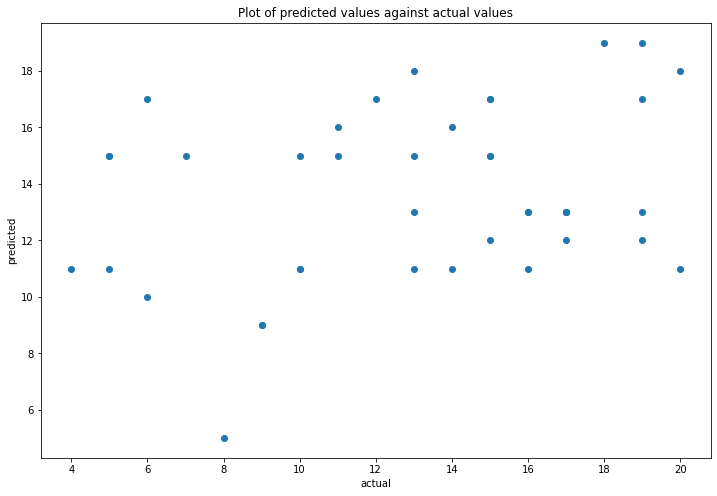

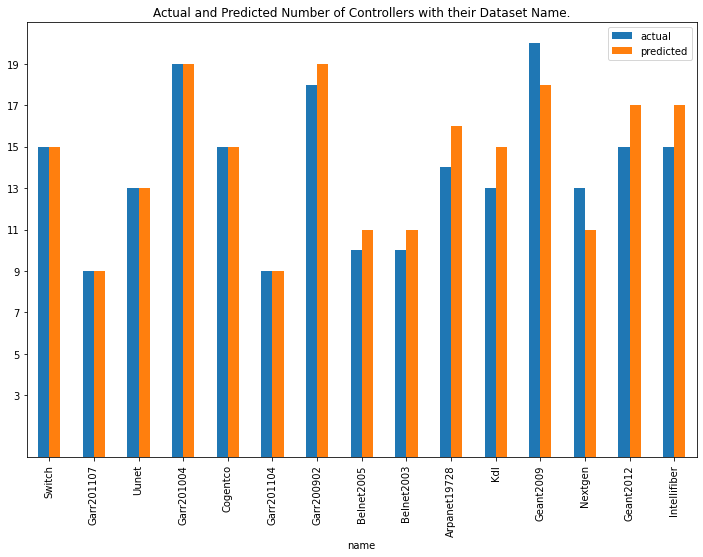

,actual,predicted,name
15,11,15,Bellsouth
9,14,16,Arpanet19728
100,19,12,Globenet
132,13,15,Kdl
68,17,13,Garr199904
95,20,18,Geant2009
159,7,15,Pern
162,16,11,Psinet
147,13,11,Nextgen
182,15,15,Switch


In [28]:
from sklearn.neighbors import KNeighborsRegressor
kn=KNeighborsRegressor(n_neighbors=5)
kn_results=eval_model(kn,'knn')
plot_model(kn_results)
plot_cityAP(kn_results)
kn_results

lr model has a test mean_absolute_error of 3.730
lr model has a train mean_absolute_error of 4.436


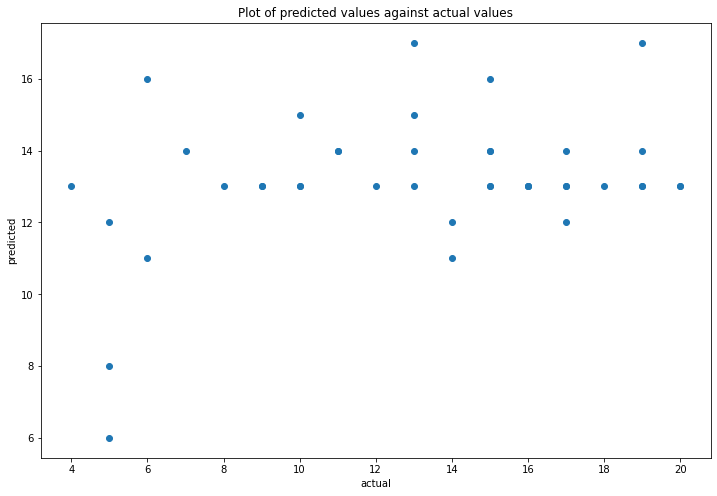

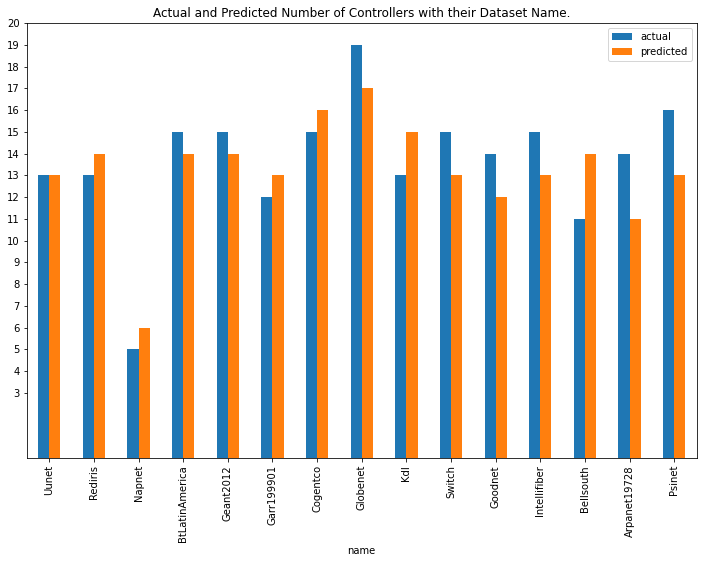

,actual,predicted,name
15,11,14,Bellsouth
9,14,11,Arpanet19728
100,19,17,Globenet
132,13,15,Kdl
68,17,13,Garr199904
95,20,13,Geant2009
159,7,14,Pern
162,16,13,Psinet
147,13,17,Nextgen
182,15,13,Switch


In [20]:
lr=LinearRegression()
lr_results=eval_model(lr,'lr')
plot_model(lr_results)
plot_cityAP(lr_results)
lr_results

rf model has a test mean_absolute_error of 1.884
rf model has a train mean_absolute_error of 1.334


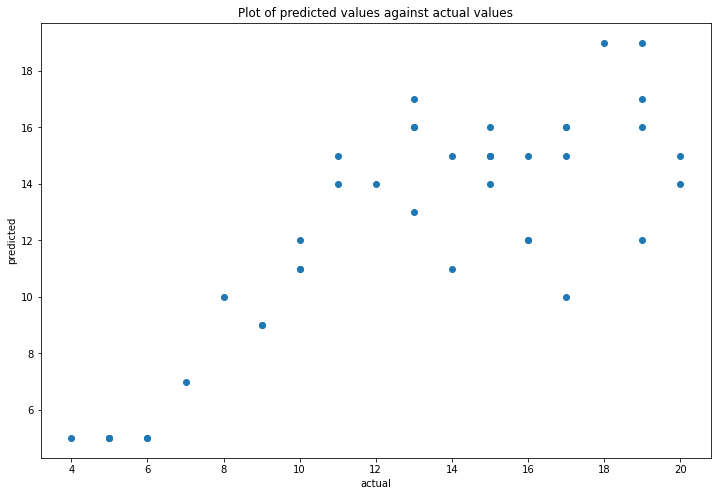

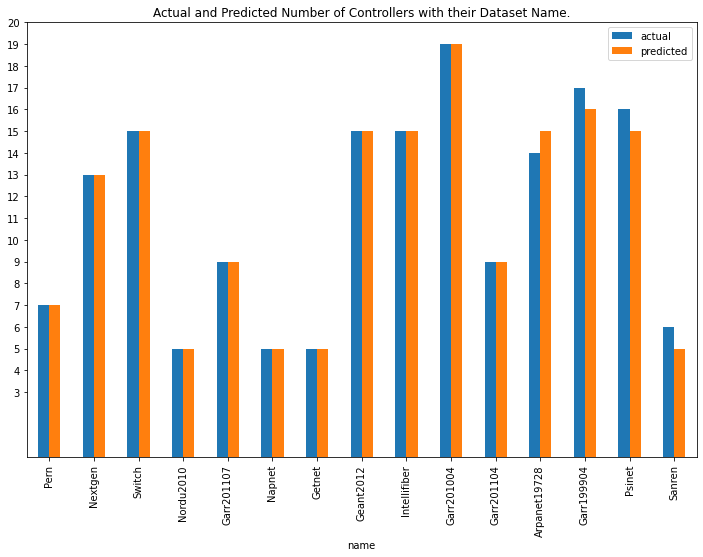

,actual,predicted,name
15,11,14,Bellsouth
9,14,15,Arpanet19728
100,19,17,Globenet
132,13,16,Kdl
68,17,16,Garr199904
95,20,15,Geant2009
159,7,7,Pern
162,16,15,Psinet
147,13,13,Nextgen
182,15,15,Switch


In [21]:
rf=RandomForestRegressor(n_estimators=200,max_depth=10,min_samples_split=3,random_state=12)
rf_results=eval_model(rf,'rf')
plot_model(rf_results)
plot_cityAP(rf_results)
rf_results

xgb model has a test mean_absolute_error of 2.043
xgb model has a train mean_absolute_error of 0.406


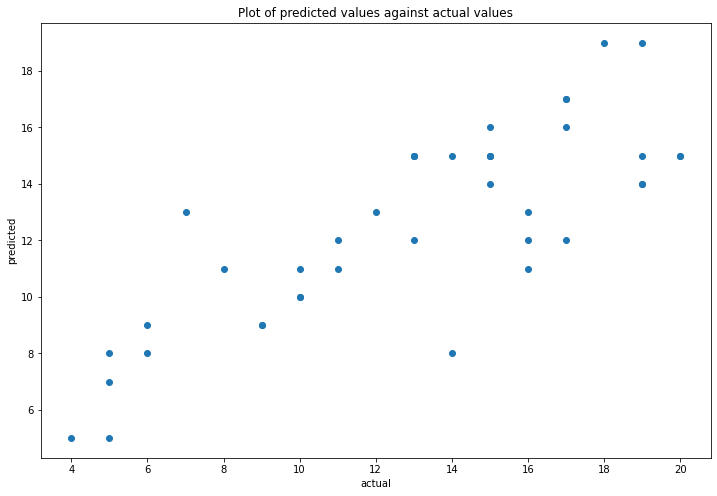

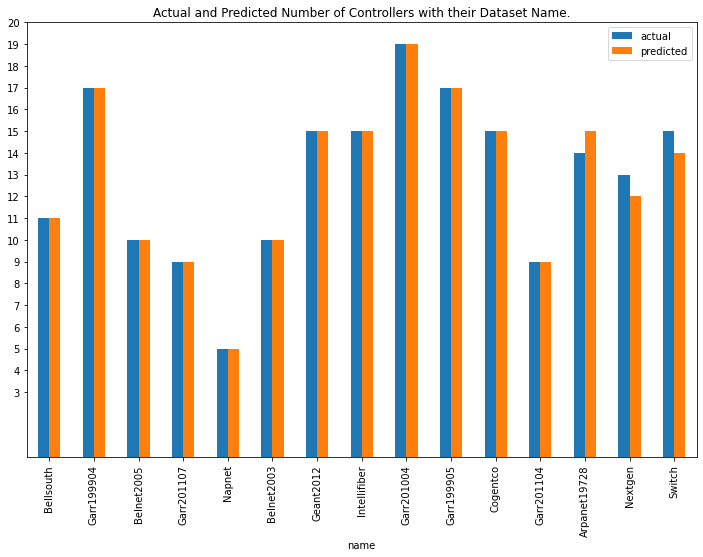

,actual,predicted,name
15,11,11,Bellsouth
9,14,15,Arpanet19728
100,19,14,Globenet
132,13,15,Kdl
68,17,17,Garr199904
95,20,15,Geant2009
159,7,13,Pern
162,16,11,Psinet
147,13,12,Nextgen
182,15,14,Switch


In [22]:
xgb=XGBRegressor(n_estimators=200 , max_depth=6   , learning_rate=0.05,colsample_bytree=0.2,
                  random_state=12,subsample=0.8,verbosity=0,objective='reg:linear')
xgb_results=eval_model(xgb,'xgb')
plot_model(xgb_results)
plot_cityAP(xgb_results)
xgb_results

In [23]:
results_df=pd.DataFrame(np.stack(results),columns=['fit_time','pred_time','train_mae','test_mae','model'])
results_df[['fit_time','pred_time','train_mae','test_mae']]=results_df[['fit_time','pred_time','train_mae','test_mae']].astype('float')
results_df.drop_duplicates(['model'],keep='last',inplace=True)
results_df

,fit_time,pred_time,train_mae,test_mae,model
0,0.007172,0.006639,3.390244,3.829268,knn
1,0.028950,0.004289,4.436261,3.729883,lr
2,0.580435,0.036671,1.334114,1.883536,rf
3,0.134105,0.004770,0.406236,2.043185,xgb


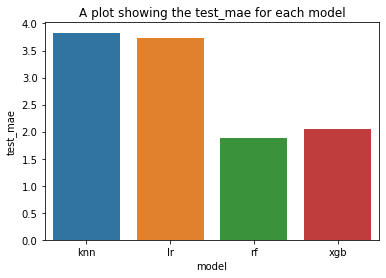

In [24]:
sns.barplot(data=results_df,x='model',y='test_mae')
plt.title('A plot showing the test_mae for each model')
plt.show()

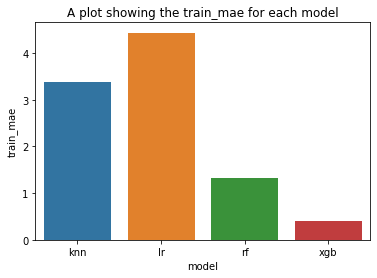

In [25]:
sns.barplot(data=results_df,x='model',y='train_mae')
plt.title('A plot showing the train_mae for each model')
plt.show()

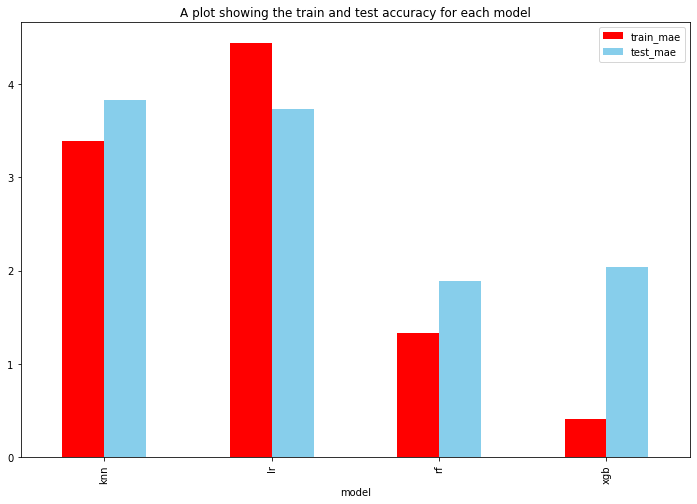

In [26]:
results_df.plot(y=['train_mae','test_mae'],x='model',kind='bar', stacked=False, color=['red', 'skyblue'],figsize=(12,8))
plt.title('A plot showing the train and test accuracy for each model')
plt.show()